In [2]:
import scipy
import random
import portpy.photon as pp
import numpy as np
from cvxpy import *
from scipy import sparse
import sklearn.metrics
import cProfile
import time
import sys
import psutil
from sklearn.decomposition import PCA
from scipy.linalg import hadamard
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.optimize import lsq_linear
import scipy.sparse

In [3]:
data_dir = r'../data'
data = pp.DataExplorer(data_dir=data_dir)
patient_id = 'Lung_Phantom_Patient_1'
data.patient_id = patient_id
ct = pp.CT(data)
structs = pp.Structures(data)
beams = pp.Beams(data)
opt_params = data.load_config_opt_params(protocol_name='Lung_2Gy_30Fx')
structs.create_opt_structures(opt_params)
inf_matrix_sparse = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)
protocol_name = 'Lung_2Gy_30Fx'
clinical_criteria = pp.ClinicalCriteria(data, protocol_name)
plan_sparse = pp.Plan(ct, structs, beams, inf_matrix_sparse, clinical_criteria)
opt = pp.Optimization(plan_sparse, opt_params=opt_params)
opt.create_cvxpy_problem()

sol_sparse = opt.solve(solver='MOSEK', verbose=True)
dose_sparse_1d = plan_sparse.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_sparse.get_num_of_fractions())
x_sparse =sol_sparse['optimal_intensity'] * plan_sparse.get_num_of_fractions()

beams_full = pp.Beams(data, load_inf_matrix_full=True)
inf_matrix_full = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams_full, is_full=True)
plan_full = pp.Plan(ct, structs, beams, inf_matrix_full, clinical_criteria)
dose_full_1d = plan_full.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_full.get_num_of_fractions())

A_dense = plan_full.inf_matrix.A
A_sparse = plan_sparse.inf_matrix.A


creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done
                                     CVXPY                                     
                                     v1.5.1                                    
(CVXPY) Jun 06 12:32:11 AM: Your problem has 1946 variables, 110663 constraints, and 0 parameters.
(CVXPY) Jun 06 12:32:11 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 06 12:32:11 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 06 12:32:11 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 06 12:32:11 AM: Your problem is compiled with the CPP canonicalization backend.
------------------------------------

(CVXPY) Jun 06 12:32:14 AM:   Problem status  : PRIMAL_AND_DUAL_FEASIBLE
(CVXPY) Jun 06 12:32:14 AM:   Solution status : OPTIMAL
(CVXPY) Jun 06 12:32:14 AM:   Primal.  obj: 4.2045404128e+01    nrm: 1e+02    Viol.  con: 5e-06    var: 6e-07    cones: 0e+00  
(CVXPY) Jun 06 12:32:14 AM:   Dual.    obj: 4.2045404171e+01    nrm: 6e+03    Viol.  con: 0e+00    var: 1e-08    cones: 0e+00  
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jun 06 12:32:14 AM: Problem status: optimal
(CVXPY) Jun 06 12:32:14 AM: Optimal value: 4.205e+01
(CVXPY) Jun 06 12:32:14 AM: Compilation took 9.823e-01 seconds
(CVXPY) Jun 06 12:32:14 AM: Solver (including time spent in interface) took 1.810e+00 seconds
Creating BEV..
Loading full influence matrix..
Done


In [4]:
opt = pp.Optimization(plan_full, opt_params=opt_params)
opt.create_cvxpy_problem()

sol_full = opt.solve(solver='MOSEK', verbose=False)

x_full = sol_full['optimal_intensity'] * plan_full.get_num_of_fractions()

Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done


In [5]:
start_time = time.time()

def apply_JL_lemma(A_dense, k, eps):
    
    m, n = A_dense.shape    
   
    R = np.random.normal(0, 1, (n, k)) / np.sqrt(k)

    R = R / np.linalg.norm(R, axis=0)

   
    projected_matrix_1 = np.dot(A_dense, R)

    def linear_map_1(v):
        return (1 / np.sqrt(k)) * np.dot(R.T, v)

    return projected_matrix_1, linear_map_1

# اعمال جانسون-لیندن‌استراوس بر روی ماتریس اصلی برای کاهش بُعد و اعمال اپسیلون 
projected_matrix_1, linear_map_1 = apply_JL_lemma(A_dense, k=542, eps=0.01)

end_time = time.time()

total_execution_time = end_time - start_time
print(f"زمان ساخت  {total_execution_time} ثانیه")

projected_matrix_1[:4,:]


زمان ساخت  0.28288984298706055 ثانیه


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
JL_1 = projected_matrix_1.transpose()
S = JL_1
A = A_dense
p = dose_full_1d
print(f' S = {S.shape}\n A = {A.shape}\n p = {p.shape}')

 S = (542, 60183)
 A = (60183, 542)
 p = (60183,)


<center> 
Minimize $\lVert Ax - p \rVert_{2}^2$
</center>
<center>
subject to $x \succeq 0$
</center>

                                                            p = دوزتجویزی

In [7]:
start_time = time.time()

# حل مسئله کمترین مربعات با قید نامنفی بودن x
sol_dense = lsq_linear (A, p, bounds=(0, np.inf))

end_time = time.time ()

total_execution_time = end_time - start_time
print(f"زمان حل مسُله  {total_execution_time} ثانیه")

# چاپ بردار x بهینه
# print(f"بردار x بهینه: {result.x}")


زمان حل مسُله  0.6230940818786621 ثانیه


<center> 
Minimize $\lVert SAx - Sp \rVert_{2}^2$
</center>
<center>
subject to $x \succeq 0$
</center>

In [8]:
start_time = time.time()

# حل مسئله کمترین مربعات با قید نامنفی بودن x
sol_JL_1 = lsq_linear (S @ A , S @ p, bounds=(0, np.inf))

end_time = time.time()

total_execution_time = end_time - start_time
print(f"زمان حل مسُله  {total_execution_time} ثانیه")

# print(f"بردار x بهینه: {x_JL_1.x}")


زمان حل مسُله  0.24587202072143555 ثانیه


In [38]:
x_dense = sol_dense.x
x_Jl_1 = sol_JL_1.x

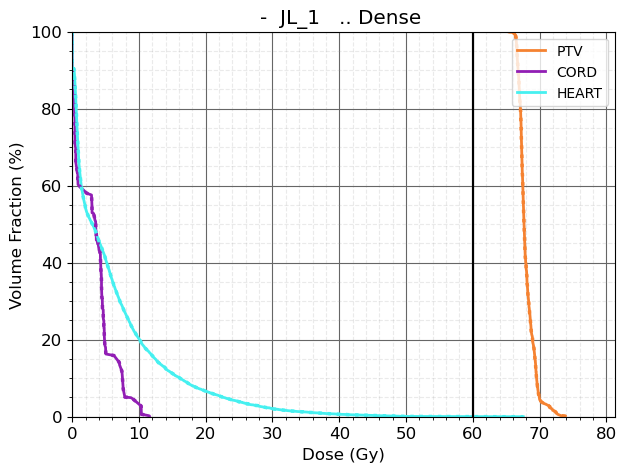

Done!


In [39]:
# DVH

dose_full = plan_full.inf_matrix.A @ x_dense
dose_JL_1 = plan_full.inf_matrix.A @ x_Jl_1


fig, ax = plt.subplots(figsize=(7, 5))
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
ax = pp.Visualization.plot_dvh(plan_full, dose_1d=dose_JL_1, struct_names=struct_names, style='solid', ax=ax)
ax = pp.Visualization.plot_dvh(plan_full, dose_1d=dose_full, struct_names=struct_names, style='dotted', ax=ax)
ax.set_title('-  JL_1   .. Dense ')
plt.show()
print('Done!')

In [41]:
# نوع داده
print("Data Type:", dose_JL1.dtype)

# ابعاد
print("Shape:", dose_JL1.shape)

# تعداد کل عناصر
print("Size:", dose_JL1.size)


NameError: name 'dose_JL1' is not defined

In [44]:
import pandas as pd

# تبدیل numpy.ndarray به DataFrame
dose_JL1_df = pd.DataFrame(dose_JL1)

# استفاده از متد describe روی DataFrame
description = dose_JL1_df.describe()

# نمایش توضیحات
print(description)


NameError: name 'dose_JL1' is not defined

In [45]:
# تست: بررسی حفظ فاصله
# تولید دو نقطه تصادفی از ماتریس اصلی
random_indices = np.random.choice(A_dense.shape[0], 2, replace=False)
point1 = A_dense[random_indices[0]]
point2 = A_dense[random_indices[1]]

# محاسبه فواصل نقاط در ماتریس اصلی
distance_original = np.linalg.norm(point1 - point2)

# محاسبه فواصل نقاط در ماتریس کاهش یافته
distance_projected_1 = np.linalg.norm(linear_map_1(point1) - linear_map_1(point2))

print(f"Distance in original matrix: {distance_original}")
print(f"Distance in reduced matrix: {distance_projected_1}")




Distance in original matrix: 0.01944325864315033
Distance in reduced matrix: 0.0008366842109406076


In [46]:
##  بررسی  پراکندگی ماتریس

is_sparse = sparse.issparse(projected_matrix_1)
is_sparse

False

In [47]:
#  تعداد عناصر غیر صفر
num_non_zero_elements_dense = np.count_nonzero(S)/32619186
print("تعداد عناصر غیر صفر در ماتریس S:", num_non_zero_elements_dense)

num_non_zero_elements_dense = np.count_nonzero(S @ A)/293764
print("تعداد عناصر غیر صفر در ماتریس S.A:", num_non_zero_elements_dense)

num_non_zero_elements_A_full = np.count_nonzero(A_dense)/32619186
print("تعداد عناصر غیر صفر در ماتریس چگال:", num_non_zero_elements_A_full)

تعداد عناصر غیر صفر در ماتریس S: 0.8515859960453949
تعداد عناصر غیر صفر در ماتریس S.A: 1.0
تعداد عناصر غیر صفر در ماتریس چگال: 0.3151234981768092


In [48]:
A.shape

(60183, 542)

In [49]:
# x_A_full= sol_ls_A_full[0]
#print(f'x_A_full :\t {x_A_full[0:6]}')

cost = cp.sum_squares((A @ x_dense  - A @ x_JL_1  )/ cp.norm(A @ x_dense))
prob1 = cp.Problem(Minimize(cost))
prob1.solve(solver='MOSEK', verbose=False)

NameError: name 'x_JL_1' is not defined

In [18]:
x_A_full= sol_ls_A_full[0]
print(f'x_A_full :\t {x_A_full[0:6]}')

cost = cp.sum_squares((A @ x_JL_1 - d )/ cp.norm(d))
prob2 = cp.Problem(Minimize(cost))
prob2.solve(solver='MOSEK', verbose=False)

NameError: name 'sol_ls_A_full' is not defined

In [51]:
x_JL_1 = sol_JL_1[0]
print(f'x_JL_1 :\t {x_JL_1[0:6]}')

cost = sum_squares(JL_1 @ A @ x_JL_1  -  JL_1 @ d)
prob = Problem(Minimize(cost))
prob.solve()

KeyError: 0

In [52]:
nonzero_count = np.count_nonzero(A_full)
print("تعداد مقادیر غیر صفر ماتریس کامل: ", nonzero_count)
num_non_zero = np.count_nonzero(JL_1 @ A)
print("تعداد عناصر غیر صفر در ماتریس SA :", num_non_zero)

NameError: name 'A_full' is not defined

In [56]:
sol_ls_A_full = scipy.sparse.linalg.lsqr(A_dense, dose_sparse_1d)
x_A_full = sol_ls_A_full[0]

relative_error = np.linalg.norm(x_A_full - x_Jl_1) / np.linalg.norm(x_A_full)
print("خطای نسبی بین دو بردار:", relative_error)


خطای نسبی بین دو بردار: 0.15506539794081328


## تعداد عناصر غیرصفر  ۱/۱۰۰ تعداد عناصر غیر صفر ماتریس کامل  شده است

In [53]:
## تابع (هدف)خطای میانگین مربعات
## MSE = Mean Squared Error

d_true = p          # دوز تجویزی
d_pred = A @ x_JL_1   # دوز پیش‌بینی شده

MSE = np.mean((d_true - d_pred) ** 2)
print("Mean Squared Error :", MSE)


NameError: name 'x_JL_1' is not defined

In [54]:
## تابع (هدف)خطای میانگین مربعات
## MSE = Mean Squared Error

d_true = A @ x_dense         # دوز واقعی
d_pred = A @ x_JL_1   # دوز پیش‌بینی شده

MSE = np.mean((d_true - d_pred) ** 2)
print("Mean Squared Error :", MSE)


NameError: name 'x_JL_1' is not defined

In [17]:
import numpy as np

def calculate_relative_error(vector1, vector2):
   
    array1 = np.array(x_A_full)
    array2 = np.array(x_JL_1)

    norm_vector2 = np.linalg.norm(x_A_full)

    relative_error = np.linalg.norm(x_A_full - x_JL_1) / norm_vector2

    return relative_error

error = calculate_relative_error(x_A_full, x_JL_1)
print(f"نرم خطای نسبی بین دو بردار: {error}")


NameError: name 'x_A_full' is not defined

In [46]:
import numpy as np

def calculate_absolute_error(vector1, vector2):
    array1 = np.array(x_A_full)
    array2 = np.array(x_JL_1)

    absolute_error = np.linalg.norm(array1 - array2, ord=1) 

    return absolute_error


error = calculate_absolute_error(x_A_full, x_JL_1)
print(f"نرم خطای مطلق بین دو بردار: {error}")


نرم خطای مطلق بین دو بردار: 140.93318675719672


In [18]:
memory_usage_sol_ls_JL_1 = sys.getsizeof(sol_ls_JL_1 )
megabyte_size_sol_ls_JL_1 = memory_usage_sol_ls_JL_1 / 1024 / 1024

print(f"میزان حافظه sol_ls_JL_1 : {megabyte_size_sol_ls_JL_1} مگابایت")

میزان حافظه sol_ls_JL_1 : 0.00011444091796875 مگابایت


In [49]:
memory_usage_JL_1 = sys.getsizeof(JL_1 )
megabyte_size_JL_1 = memory_usage_JL_1 / 1024 / 1024

print(f"میزان حافظه ساخت JL_1 : {megabyte_size_JL_1} مگابایت")

میزان حافظه ساخت JL_1 : 0.0001220703125 مگابایت


In [59]:
memory_usage_JL_2 = sys.getsizeof(JL_2 )
megabyte_size_JL_2 = memory_usage_JL_2 / 1024 / 1024

print(f"میزان حافظه ساخت JL_1 : {megabyte_size_JL_2} مگابایت")

میزان حافظه ساخت JL_1 : 27633.61743927002 مگابایت


In [20]:
r1 = np.linalg.matrix_rank(JL_1 @ A_full ) 
#r2 = np.linalg.matrix_rank(A_full)      
print( f' رتبه ماتریس تقریب = {r1}')

 رتبه ماتریس تقریب = 542


In [4]:
# بررسی  با 60183



start_time = time.time()

#k = 60183
#eps = 0.01
m, n = A_full.shape

    
def apply_JL_lemma(A_full, k, eps):
   
    # eps: مقدار ارتباط فاصله
    m, n = A_full.shape    

    R = np.random.normal(0, 1, (n, k)) / np.sqrt(k)

    # نرمال سازی ماتریس
    R = R / np.linalg.norm(R, axis=0)

    projected_matrix_2 = np.dot(A_full, R)

    def linear_map_2(v):
        return (1 / np.sqrt(k)) * np.dot(R.T, v)

    return projected_matrix_2, linear_map_2

# اعمال قضیه جانسون-لیندن‌استراوس بر روی ماتریس اصلی برای کاهش بُعد و مقدار epsilon = 0.1
projected_matrix_2, linear_map_2 = apply_JL_lemma(A_full, k=m, eps=0.1)


end_time = time.time()

total_execution_time = end_time - start_time
print(f"زمان ساخت  {total_execution_time} ثانیه")

زمان ساخت  26.283906936645508 ثانیه


In [5]:
JL_2 = projected_matrix_2
A = A_full
d = dose_full_1d
print(f'JL_2 = {JL_2.shape}\nA = {A.shape}\nd = {d.shape}')

JL_2 = (60183, 60183)
A = (60183, 542)
d = (60183,)


In [6]:
start_time = time.time()

sol_ls_JL_2 = scipy.sparse.linalg.lsqr(JL_2 @ A , JL_2 @ d)


end_time = time.time()

total_execution_time = end_time - start_time
print(f"زمان حل کمترین مربعات{total_execution_time} ثانیه")

زمان حل کمترین مربعات36.6832172870636 ثانیه


In [7]:
x_JL_2 = sol_ls_JL_2[0]
print(f'x_JL_2 :\t {x_JL_2[0:6]}')


cost = cp.sum_squares((d  - A @ x_JL_2  )/ cp.norm(d))
prob = cp.Problem(Minimize(cost))
prob.solve(solver='MOSEK', verbose=False)

x_JL_2 :	 [ 6.32633089  0.76392897  1.82877719  2.55278294 10.17803847  8.1373959 ]


0.0001230028222348172

In [12]:
x_JL_2 = sol_ls_JL_2[0]

In [39]:
cost = cp.sum_squares((d  - A @ x_JL_2  )/ cp.norm(d))
prob = cp.Problem(Minimize(cost))
prob.solve(solver='MOSEK', verbose=False)

7.538364969628534e-05

In [25]:
r1 = np.linalg.matrix_rank(projected_matrix_2 @ A_full ) 
r2 = np.linalg.matrix_rank(A_full)      
print( f' رتبه ماتریس تقریب = {r1}\nرتبه ماتریس کامل = {r2}')

 رتبه ماتریس تقریب = 542
رتبه ماتریس کامل = 542


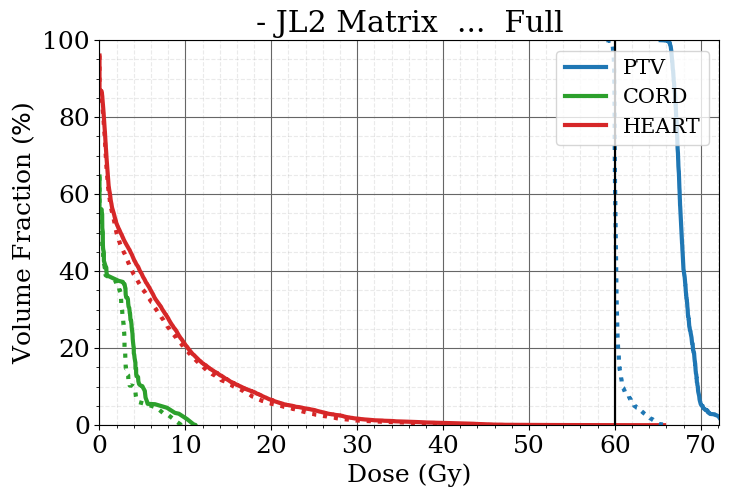

Done!


In [15]:
# DVH Plot
dose_JL2 = plan_full.inf_matrix.A @ x_JL_2 
dose_full = plan_full.inf_matrix.A @ x_full



fig, ax = plt.subplots(figsize=(8, 5))
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
ax = pp.Visualization.plot_dvh(plan_full, dose_1d= dose_JL2, struct_names=struct_names, style='solid', ax=ax)
ax = pp.Visualization.plot_dvh(plan_full, dose_1d=dose_full, struct_names=struct_names, style='dotted', ax=ax)
ax.set_title('- JL2 Matrix  ...  Full')
plt.show()
print('Done!')

In [22]:
# نوع داده
print("Data Type:", dose_JL2.dtype)

# ابعاد
print("Shape:", dose_JL2.shape)

# تعداد کل عناصر
print("Size:", dose_JL2.size)


Data Type: float64
Shape: (60183,)
Size: 60183


In [26]:
import pandas as pd

# تبدیل numpy.ndarray به DataFrame
dose_JL2_df = pd.DataFrame(dose_JL2)

# استفاده از متد describe روی DataFrame
description = dose_JL2_df.describe()

# نمایش توضیحات
print(description)


                  0
count  60183.000000
mean       6.567914
std       12.136572
min        0.000000
25%        0.343364
50%        1.415731
75%        6.688543
max       74.210873


In [25]:
import pandas as pd

# تبدیل numpy.ndarray به DataFrame
dose_full_df = pd.DataFrame(dose_full)

# استفاده از متد describe روی DataFrame
description = dose_full_df.describe()

# نمایش توضیحات
print(description)


                  0
count  60183.000000
mean       5.840937
std       10.741495
min        0.000000
25%        0.297954
50%        1.261218
75%        6.208031
max       65.613516


In [24]:
# نوع داده
print("Data Type:", dose_full.dtype)

# ابعاد
print("Shape:", dose_full.shape)

# تعداد کل عناصر
print("Size:", dose_full.size)




Data Type: float64
Shape: (60183,)
Size: 60183


In [60]:
## تابع (هدف)خطای میانگین مربعات
## MSE = Mean Squared Error

d_true = A @ x_A_full         # دوز واقعی
d_pred = A @ x_JL_2   # دوز پیش‌بینی شده

MSE = np.mean((d_true - d_pred) ** 2)
print("Mean Squared Error :", MSE)


Mean Squared Error : 0.013226262767956241


In [61]:
## تابع (هدف)خطای میانگین مربعات
## MSE = Mean Squared Error

d_true = d         # دوز واقعی
d_pred = A @ x_JL_2   # دوز پیش‌بینی شده

MSE = np.mean((d_true - d_pred) ** 2)
print("Mean Squared Error :", MSE)


Mean Squared Error : 0.013224769537129883


In [23]:
# تولید دو نقطه تصادفی از ماتریس اصلی
random_indices = np.random.choice(A_full.shape[0], 2, replace=False)
point1 = A_full[random_indices[0]]
point2 = A_full[random_indices[1]]

# محاسبه فواصل نقاط در ماتریس اصلی
distance_original = np.linalg.norm(point1 - point2)

# محاسبه فواصل نقاط در ماتریس کاهش یافته
distance_projected_2 = np.linalg.norm(linear_map_2(point1) - linear_map_2(point2))

print(f"Distance in original matrix: {distance_original}")
print(f"Distance in reduced matrix: {projected_matrix_2}")


Distance in original matrix: 0.5519641041755676
Distance in reduced matrix: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [30]:
x_JL_2 = sol_ls_JL_2[0]
cost = sum_squares(A @ x_JL_2 -  d)
prob_original = Problem(Minimize(cost))
prob_original.solve()

942.2712308579363

In [52]:
import cvxpy as cp

x_A_full = sol_ls_A_full[0]
print(f'x_A_full :\t {x_A_full[0:6]}')

# تغییر تابع هدف به نرم فروبنیوس
cost = cp.norm(A @ x_A_full - A @ x_JL_2, "fro")/ cp.norm(A @ x_A_full, "fro")


# تغییر مسئله بهینه‌سازی
prob = cp.Problem(cp.Minimize(cost))

# حل مسئله
prob.solve()


x_A_full :	 [ 6.56993354  0.52249962  1.0313918   2.38895931 10.26382985  8.2465346 ]


0.008333098840964736

In [42]:
import numpy as np

def calculate_relative_error(vector1, vector2):
   
    array1 = np.array(x_A_full)
    array2 = np.array(x_JL_2)

    norm_vector2 = np.linalg.norm(x_A_full)

    relative_error = np.linalg.norm(x_A_full - x_JL_2) / norm_vector2

    return relative_error

error = calculate_relative_error(x_A_full, x_JL_2)
print(f"نرم خطای نسبی بین دو بردار: {error}")


نرم خطای نسبی بین دو بردار: 0.031026630637414523


In [45]:
import numpy as np

def calculate_absolute_error(vector1, vector2):
    array1 = np.array(x_A_full)
    array2 = np.array(x_JL_2)

    absolute_error = np.linalg.norm(array1 - array2, ord=1) 

    return absolute_error


error = calculate_absolute_error(x_A_full, x_JL_2)
print(f"نرم خطای مطلق بین دو بردار: {error}")


نرم خطای مطلق بین دو بردار: 125.98748750518801


In [19]:
def calculate_absolute_error(matrix1, matrix2):
    
    array1 = np.array(A_full)
    array2 = np.array(JL_2 @ A)

    absolute_error = np.sum(np.abs(array1 - array2))
    return absolute_error


absolute_errorr = calculate_absolute_error(A_full, JL_2 @ A)
print(f"نرم خطای مطلق: {absolute_errorr}")


نرم خطای مطلق: 1795243.967586711


In [22]:
import numpy as np

def calculate_relative_error(matrix1, matrix2):
    array1 = np.array(A_full)
    array2 = np.array(JL_2 @ A)

    norm_error = np.linalg.norm(array1 - array2, 'fro') 
    
    return norm_error

error = calculate_relative_error(A_full, JL_2 @ A)
print(f"نرم خطای مطلق بین دو ماتریس: {error}")


نرم خطای مطلق بین دو ماتریس: 739.3085460329893


In [20]:
import numpy as np

def calculate_relative_error(matrix1, matrix2):
    array1 = np.array(A_full)
    array2 = np.array(JL_2 @ A)

    norm_error = np.linalg.norm(array1 - array2, 'fro') 
    norm_matrix2 = np.linalg.norm(array2, 'fro') 

    relative_error = norm_error / norm_matrix2

    return relative_error

error = calculate_relative_error(A_full, JL_2 @ A)
print(f"نرم خطای نسبی بین دو ماتریس: {error}")


نرم خطای نسبی بین دو ماتریس: 1.0147916170361297


In [66]:
#  تعداد عناصر غیر صفر
num_non_zero_elements_dense = np.count_nonzero(JL_2)/3621993489
print("تعداد عناصر غیر صفر در ماتریس JL_1:", num_non_zero_elements_dense)

num_non_zero_elements_dense = np.count_nonzero(JL_2 @ A)/32619186
print("تعداد عناصر غیر صفر در ماتریس JL_1.A:", num_non_zero_elements_dense)

num_non_zero_elements_A_full = np.count_nonzero(A_full)/32619186
print("تعداد عناصر غیر صفر در ماتریس کامل:", num_non_zero_elements_A_full)

تعداد عناصر غیر صفر در ماتریس JL_1: 0.8515859960453949
تعداد عناصر غیر صفر در ماتریس JL_1.A: 0.8515859960453949
تعداد عناصر غیر صفر در ماتریس کامل: 0.3151234981768092


In [45]:
memory_usage_sol_ls_JL_2 = sys.getsizeof(sol_ls_JL_2 )
megabyte_size_sol_ls_JL_2 = memory_usage_sol_ls_JL_2 / 1024 / 1024

print(f"میزان حافظه sol_ls_JL_1 : {megabyte_size_sol_ls_JL_2} مگابایت")

میزان حافظه sol_ls_JL_1 : 0.00011444091796875 مگابایت


In [48]:
memory_usage_JL_2 = sys.getsizeof(JL_2 )
megabyte_size_JL_2 = memory_usage_JL_2 / 1024 / 1024

print(f"میزان حافظه ساخت JL_2 : {megabyte_size_JL_2} مگابایت")

میزان حافظه ساخت JL_2 : 27633.61743927002 مگابایت


In [87]:
import numpy as np

D = np.array([[1, 2], [4, 4], [7, 7]])
M = np.array([[10, 11, 12], [13, 14, 15], [16, 17, 18]])
F = np.array([[0, -1, -2], [-3, -4, -5], [-6, -7, -8]])

# ضرب ماتریسی M @ F
MF_result = np.dot(M, F)

# ضرب ماتریسی M @ D
MD_result = np.dot(M, D)

# حل معادله با استفاده از np.linalg.lstsq
solution, residuals, rank, s = np.linalg.lstsq(MF_result, MD_result, rcond=None)

print("راه حل:")
print(solution)


راه حل:
[[-0.33333333  0.22222222]
 [-0.33333333 -0.27777778]
 [-0.33333333 -0.77777778]]
